In [1]:
# a brief introduction to scikit-learn
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets

# parameters
number_of_sample = 2000

In [2]:
# Define a class Gaussian2D to Generate the Gaussion Distribution in 2D
class Gaussian2D:
    # initialize the class
    def __init__(self,n_samples,means,eigen_values,eigen_vectors):
        # Initialize the parameters
        self.n_samples = n_samples
        self.means = means
        self.eigen_values = eigen_values
        self.eigen_vectors = eigen_vectors
    
    # generate the gaussian distribution with mean and covariance
    def generate(self):
        # Calculate the Covariance Matrix by using the eigen_vectors and eigen_values
        eigen_vector_sum = np.row_stack((self.eigen_vectors[0], self.eigen_vectors[1]))
        eigen_value_matrix = np.identity(2)
        eigen_value_matrix[0, 0] = self.eigen_values[0]
        eigen_value_matrix[1, 1] = self.eigen_values[1]
        cov = eigen_vector_sum @ eigen_value_matrix @ eigen_vector_sum.T
        # Generate the sample data
        component = np.random.multivariate_normal(self.means, cov, self.n_samples).T
        
        return component

In [3]:
# Define a class MixGaussian2D to combine the Gaussian2D
class MixGaussian2D:
    # initialize the class
    def __init__(self,n_samples,means,eigen_values,eigen_vectors,weights):
        self.n_samples = n_samples
        self.means = means
        self.eigen_values = eigen_values
        self.eigen_vectors = eigen_vectors
        self.weights = weights
    
    # combine the gaussian distribution
    def generate(self):
        number_of_components = len(self.weights)
        
        # calculate the number of sample for each component
        n_samples_per_component = np.array([int(self.weights[i]*self.n_samples) for i in range(number_of_components)])
        
        # generate the gaussian distribution
        components = []
        for i in range(number_of_components):
            component = Gaussian2D(n_samples_per_component[i],self.means[i],self.eigen_values[i],self.eigen_vectors[i]).generate()
            components.append(component)

        # combine the components
        data = np.concatenate(components,axis=1)
        return data
    
    # plot the data
    def plot(self,data):
        # plot the data
        plt.scatter(data[0,:],data[1,:],s=1)
        plt.show()

In [4]:
def generate_class(n_samples,means,eigen_values,weights,theta,lable):
    eigen_vectors = []
    # TODO: calculate the eigen_vectors
    for i in range(len(theta)):
        eigen_vectors.append([[np.cos(theta[i]),np.sin(theta[i])],[-np.sin(theta[i]),np.cos(theta[i])]])

    mix_gaussian = MixGaussian2D(n_samples,means,eigen_values,eigen_vectors,weights).generate()
    # store the data in a dataframe and label the data
    data = pd.DataFrame(mix_gaussian.T,columns=['x','y'])
    data['label'] = lable
    return data

# Class 0:
means = [[4,0],[-3,3]]
eigen_values =[[1,4],[1,4]]
theta = [0,np.pi/4]
weights = [0.66,0.34]
class0 = generate_class(number_of_sample,means,eigen_values,weights,theta,0)

# Class 1:
means = [[0,0],[-6,-4]]
eigen_values =[[1,2],[2,1]]
theta = [np.pi/3,np.pi/4]
weights = [0.75,0.25]
class1 = generate_class(number_of_sample,means,eigen_values,weights,theta,1)

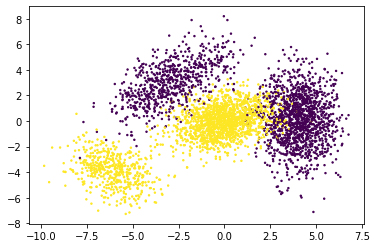

The first few rows of data:
          x         y  label
0 -0.970728  0.445103      1
1 -1.436649  0.952086      1
2  0.298719 -0.913028      1
3 -3.436509  3.308464      0
4 -4.153348  2.098713      0
Mean of the data:
x        0.073441
y        0.063725
label    0.500000
dtype: float64


In [5]:
# combine the data from Class 0 and Class 1 and shuffle the data
data = pd.concat([class0,class1])
data = data.sample(frac=1).reset_index(drop=True)

# plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
# you can remove the "c=data['label']" to see the data without label
ax.scatter(data['x'],data['y'],s=2,c=data['label'])
plt.show()
# you can use head(n) to see the first few rows of data
print("The first few rows of data:")
print(data.head(5))

# mean of the data
print("Mean of the data:")
print(data.mean())

In [6]:
# use logistic regression to classify the data
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


clf = LogisticRegression(max_iter=10000)
clf.fit(data[['x','y']],data['label'])

# test the model
pred = clf.predict(data[['x','y']])
# print few samples of the predicted labels
print(pred[:5])

# calculate the accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(data['label'],pred)
print("The accuracy is:",acc)

[1 1 1 0 1]
The accuracy is: 0.74975


In [7]:
# use kernel logistic regression to classify the data

# kernel function
def gaussian_kernel(X,sigma):
    K = np.exp(-np.sum((X[:,np.newaxis,:] - X[np.newaxis,:,:])**2,axis=2)/(2*sigma**2))
    return K

clf2 = LogisticRegression(max_iter=1000,C=1e-3)
X = data[['x','y']].values

y = data['label']
K = gaussian_kernel(X,0.2)

clf2.fit(K,y)

# test the model
pred = clf2.predict(K)
# print few samples of the predicted labels
print(pred[:5])

# calculate the accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(y,pred)
print("The accuracy is:",acc)

[1 1 1 0 0]
The accuracy is: 0.81575


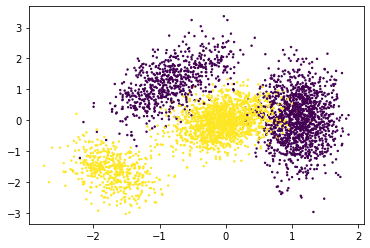

x       -9.346690e-18
y       -7.965850e-18
label    5.000000e-01
dtype: float64
[1 1 1 0 1]
The accuracy is: 0.7495


In [8]:
# normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data[['x','y']])
data[['x','y']] = scaler.transform(data[['x','y']])

# plot the data
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data['x'],data['y'],s=2,c=data['label'])
plt.show()
print(data.mean())
# train the model on the normalized data
clf3 = LogisticRegression(max_iter=10000)
clf3.fit(data[['x','y']],data['label'])

# test the model
pred = clf3.predict(data[['x','y']])
# print few samples of the predicted labels
print(pred[:5])

# calculate the accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(data['label'],pred)
print("The accuracy is:",acc)

In [9]:
clf4 = LogisticRegression(max_iter=1000)
X = data[['x','y']].values

y = data['label']
K = gaussian_kernel(X,0.2)

clf4.fit(K,y)

# test the model
pred = clf4.predict(K)
# print few samples of the predicted labels
print(pred[:5])

# calculate the accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(y,pred)
print("The accuracy is:",acc)

[1 1 1 0 0]
The accuracy is: 0.95975
